<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [94]:
# The following libraries just need to be installed once
#!pip install matplotlib
#!pip install pandas
#!pip install numpy
#!pip install scikit-learn
#!pip install scipy
#!pip install seaborn

In [95]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [96]:
#!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

### Load Data From CSV File


In [97]:
#path='D:\Coursera\IBM Data Science Professional Certificate\Course 7 - Machine Learning with Python\Week6\Final assignment\loan_train.csv'
path='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv'

df = pd.read_csv(path)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [98]:
df.shape

(346, 10)

### Convert to date time object


In [99]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [100]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [101]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

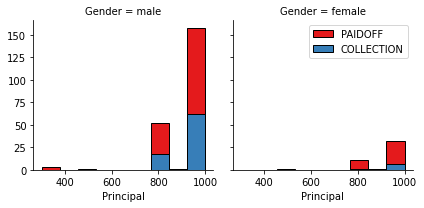

In [102]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

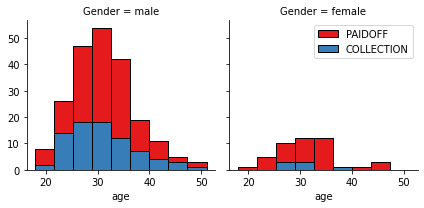

In [103]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


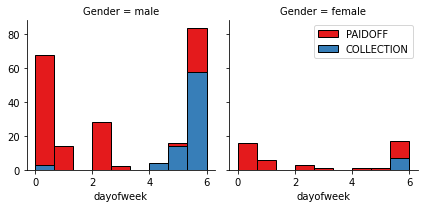

In [104]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [105]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [106]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [107]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [108]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [109]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [110]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [111]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [112]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [113]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]   

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN) - the target/label can be categorical strings
*   Decision Tree - the target/label can be categorical strings
*   Support Vector Machine - the target/label can be categorical strings
*   Logistic Regression - the target/label must be integer 1/0

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [114]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [115]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# try testing using k=5
k=5
neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
neigh
yhat = neigh.predict(X_test)
yhat[0:5]

# measure accuracy scores, which are used for binary classification
print('Train set accuracy:', metrics.accuracy_score(y_train, neigh.predict(X_train)))
print('Test set accuracy:', metrics.accuracy_score(y_test, yhat))

Train set accuracy: 0.8188405797101449
Test set accuracy: 0.7428571428571429


In [116]:
# Find the best k
Ks=10
mean_accuracy = np.zeros((Ks-1))
std_accuracy = np.zeros((Ks-1))

for n in range(1,Ks):
    # Train model and predict
    neigh=KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat=neigh.predict(X_test)
    mean_accuracy[n-1]=metrics.accuracy_score(y_test,yhat)
    std_accuracy[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
print('The best accuracy was', mean_accuracy.max(), 'with k=', mean_accuracy.argmax()+1)

The best accuracy was 0.7857142857142857 with k= 7


In [117]:
# Build the model using k=7
k=7
KNN_model = KNeighborsClassifier(n_neighbors=k).fit(X, y)  #train using the loan_train dataset
KNN_model   #the KNN model is now ready for evaluation using the loan_test dataset at the bottom

KNeighborsClassifier(n_neighbors=7)

In [118]:
# Model Evaluation using the training dataset
# The results will be compared with using the testing dataset at the bottom

yhat = KNN_model.predict(X)
print(yhat[0:5])

from sklearn import metrics
import matplotlib.pyplot as plt
print("Accuracy Score:", metrics.accuracy_score(y, yhat))

# F1 Score
from sklearn.metrics import f1_score
print('Weighted F1 Score:',f1_score(y, yhat, average='weighted'))

# Jaccard Index
from sklearn.metrics import jaccard_score
print('Jaccard Index:', jaccard_score(y, yhat, pos_label='PAIDOFF'))

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Accuracy Score: 0.8034682080924855
Weighted F1 Score: 0.7852885289164019
Jaccard Index: 0.7813504823151125


# Decision Tree


In [119]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

#Build the model
yTree=DecisionTreeClassifier(criterion='entropy', max_depth=4)
yTree.fit(X, y)  #the model is ready for testing using the testing dataset

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [120]:
# Model evaluation using the training dataset
# The results will be compared with using the testing dataset at the bottom

yhat = yTree.predict(X)
print('Predicted y:',yhat[0:5])

from sklearn import metrics
import matplotlib.pyplot as plt
print('Accuracy Score:', metrics.accuracy_score(y, yhat))

# F1 Score
from sklearn.metrics import f1_score
print('Weighted F1 Score:',f1_score(y, yhat, average='weighted'))

# Jaccard Index
from sklearn.metrics import jaccard_score
print('Jaccard Index:', jaccard_score(y, yhat, pos_label='PAIDOFF'))

Predicted y: ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF']
Accuracy Score: 0.7514450867052023
Weighted F1 Score: 0.673085302317342
Jaccard Index: 0.7470588235294118


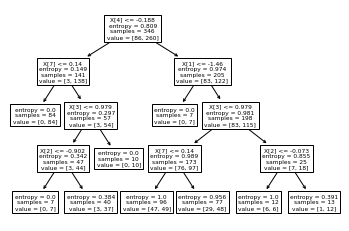

In [121]:
# Plot the decision tree
tree.plot_tree(yTree)
plt.show()

# Support Vector Machine


In [122]:
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [123]:
# Build the model
from sklearn import svm
clf = svm.SVC(kernel='rbf')  #use the default Radial Basis kernel function
clf.fit(X, y)

SVC()

In [124]:
# Model Evaluation using the training dataset
# The results will be compared with using the testing dataset at the bottom

# Predict
yhat = clf.predict(X)
yhat[0:5]

from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix
cnf_matrix=confusion_matrix(y, yhat, labels=['PAIDOFF','COLLECTION'])
print('Confusion Matrix:\n', cnf_matrix)
print('Classification Report:\n', classification_report(y, yhat))

# Accuracy Score
print('Accuracy Score:', metrics.accuracy_score(y, yhat))

# F1 Score
from sklearn.metrics import f1_score
F1_score=f1_score(y, yhat, average='weighted')
print('Weighted F1 Score:', F1_score)

# Jaccard Index
from sklearn.metrics import jaccard_score
print('Jaccard Index:', jaccard_score(y, yhat, pos_label='PAIDOFF'))

Confusion Matrix:
 [[260   0]
 [ 83   3]]
Classification Report:
               precision    recall  f1-score   support

  COLLECTION       1.00      0.03      0.07        86
     PAIDOFF       0.76      1.00      0.86       260

    accuracy                           0.76       346
   macro avg       0.88      0.52      0.46       346
weighted avg       0.82      0.76      0.66       346

Accuracy Score: 0.7601156069364162
Weighted F1 Score: 0.6647688577527595
Jaccard Index: 0.7580174927113703


# Logistic Regression


In [125]:
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline
import matplotlib.pyplot as plt

In [126]:
# The Logistic Regression library do support strings in the target/label, so you don't need to perform the followings:
#y_int=np.where(y=='PAIDOFF',1,0)    # Convert string to integers 0 or 1

In [127]:
# Build the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

LR=LogisticRegression(C=0.01, solver='liblinear').fit(X, y)
LR        #the model is ready for testing using the testing dataset at the bottom

LogisticRegression(C=0.01, solver='liblinear')

In [128]:
# Model Evaluation using the training dataset
# The results will be compared with using the testing dataset at the bottom

# Predict 0 or 1
yhat = LR.predict(X)
#print(yhat[0:5])

# Predict probabilities: P(y=0) and P(y=1)
yhat_prob=LR.predict_proba(X)
#print(yhat_prob[0:5])

# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
cnf_matrix=confusion_matrix(y, yhat, labels=['PAIDOFF','COLLECTION'])
print('Confusion Matrix:\n',cnf_matrix)

#Classification Report
print('The classification report:\n',classification_report(y, yhat))

# Accuracy Score
print('Accuracy Score:', metrics.accuracy_score(y, yhat))

# F1 Score
print('Weighted F1 Score:', f1_score(y, yhat, average='weighted'))

# Jaccard Score
from sklearn.metrics import jaccard_score
print('Jaccard score is:',jaccard_score(y, yhat, pos_label='PAIDOFF'))  

#Log Loss
from sklearn.metrics import log_loss
print('The Log Loss is:',log_loss(y, yhat_prob))

Confusion Matrix:
 [[259   1]
 [ 86   0]]
The classification report:
               precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        86
     PAIDOFF       0.75      1.00      0.86       260

    accuracy                           0.75       346
   macro avg       0.38      0.50      0.43       346
weighted avg       0.56      0.75      0.64       346

Accuracy Score: 0.7485549132947977
Weighted F1 Score: 0.6433860411789996
Jaccard score is: 0.7485549132947977
The Log Loss is: 0.5430553956239154


# Model Evaluation using Test set


In [129]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [130]:
#!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation


In [131]:
#path='D:\Coursera\IBM Data Science Professional Certificate\Course 7 - Machine Learning with Python\Week6\Final assignment\loan_test.csv'
path='https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv'
test_df = pd.read_csv(path)
test_df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [132]:
# Data pre-processing for the test data
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
test_df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,Bechalor,male


In [133]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,Master or Above,male,3,0
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,High School or Below,female,3,0
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,college,male,4,1
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,Bechalor,male,4,1


In [134]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,Master or Above,0,3,0
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,High School or Below,1,3,0
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,college,0,4,1
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,Bechalor,0,4,1


In [135]:
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [136]:
X_test=Feature
y_test=test_df['loan_status'].values
print(X_test.shape)
print(y_test.shape)

(54, 8)
(54,)


In [137]:
X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)
X[0:5] 

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [138]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [139]:
print('KNN Model Evaluation using the testing dataset loan_test.csv\n')

yhat=KNN_model.predict(X_test)

print("Accuracy Score:", metrics.accuracy_score(y_test, yhat))

# F1 Score
from sklearn.metrics import f1_score
print('Weighted F1 Score:',f1_score(y_test, yhat, average='weighted'))

# Jaccard Index
from sklearn.metrics import jaccard_score
print('Jaccard Index:', jaccard_score(y_test, yhat, pos_label='PAIDOFF'))

KNN Model Evaluation using the testing dataset loan_test.csv

Accuracy Score: 0.6666666666666666
Weighted F1 Score: 0.6328400281888654
Jaccard Index: 0.6538461538461539


In [140]:
print('Decision Tree Model Evaluation using the testing dataset loan_test.csv\n')

yHat = yTree.predict(X_test)

print("Accuracy Score:", metrics.accuracy_score(y_test, yhat))

# F1 Score
print('Weighted F1 Score:', f1_score(y_test, yhat, average='weighted'))

# Jaccard Score
from sklearn.metrics import jaccard_score
print('Jaccard score is:',jaccard_score(y_test, yhat, pos_label='PAIDOFF'))


Decision Tree Model Evaluation using the testing dataset loan_test.csv

Accuracy Score: 0.6666666666666666
Weighted F1 Score: 0.6328400281888654
Jaccard score is: 0.6538461538461539


In [141]:
print('SVC Model Evaluation using the testing dataset loan_test.csv\n')

yhat = clf.predict(X_test)
yhat[0:5]

# F1 Score
print('Weighted F1 Score:', f1_score(y_test, yhat, average='weighted'))
      
from sklearn.metrics import jaccard_score
print('Jaccard score is:',jaccard_score(y_test, yhat, pos_label='PAIDOFF'))


SVC Model Evaluation using the testing dataset loan_test.csv

Weighted F1 Score: 0.6212664277180406
Jaccard score is: 0.7222222222222222


In [143]:
print('Logistic Regression Model Evaluation using the testing dataset loan_test.csv\n')

yhat = LR.predict(X_test)
yhat_prob=LR.predict_proba(X_test)

# F1 Score
print('Weighted F1 Score:', f1_score(y_test, yhat, average='weighted'))

# Jaccard Score
from sklearn.metrics import jaccard_score
print('Jaccard score is:',jaccard_score(y_test, yhat, pos_label='PAIDOFF'))

#Log Loss
from sklearn.metrics import log_loss
print('The Log Loss is:',log_loss(y_test, yhat_prob))

Logistic Regression Model Evaluation using the testing dataset loan_test.csv

Weighted F1 Score: 0.6304176516942475
Jaccard score is: 0.7407407407407407
The Log Loss is: 0.5932154076674484


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
